In [1]:
#Import Necessary Modules
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

import re
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFKC
from tokenizers.processors import TemplateProcessing

from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import os
import csv
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from tqdm.auto import tqdm
from pathlib import Path
from random import shuffle, seed

#Set Tokenisers Parallelism
os.environ['TOKENIZERS_PARALLELISM'] = "false"

#Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {device}")

PyTorch Version: 2.6.0+cu124
Device: cuda


In [2]:
#Getting the Data and Creating the Dataframe
df = pd.read_json('/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json', lines = True)
df.drop(['link', 'authors', 'date'], axis = 1, inplace = True)
df = df[['category', 'headline', 'short_description']]
df.head()

,category,headline,short_description
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha..."
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to..."
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...


In [3]:
#Visualising Minimum, Maximum and Median Lengths of Headlines and Description
df_len = pd.DataFrame()
df_len['category'] = df['category']
df_len['news_length'] = df['headline'].apply(lambda x : len(x.split())) + df['short_description'].apply(lambda x :  len(x.split()))

### Dropped Columns: Rationale

The following columns were removed from the dataset:

* `author`: May introduce bias and is not relevant to the content's category
* `link`: Contains no semantic or textual information useful for classification
* `date`: Could influence predictions based on time trends rather than content

Only the `headline` and `short_description` fields were retained, as they provide concise, meaningful summaries of the articles suitable for text classification.

Number of Categories : 42
        category                                           headline  \
0             35  Over 4 Million Americans Roll Up Sleeves For O...   
1             35  American Airlines Flyer Charged, Banned For Li...   
2              5  23 Of The Funniest Tweets About Cats And Dogs ...   
3             22  The Funniest Tweets From Parents This Week (Se...   
4             35  Woman Who Called Cops On Black Bird-Watcher Lo...   
...          ...                                                ...   
209522        32  RIM CEO Thorsten Heins' 'Significant' Plans Fo...   
209523        28  Maria Sharapova Stunned By Victoria Azarenka I...   
209524        28  Giants Over Patriots, Jets Over Colts Among  M...   
209525        28  Aldon Smith Arrested: 49ers Linebacker Busted ...   
209526        28  Dwight Howard Rips Teammates After Magic Loss ...   

                                        short_description  
0       Health experts said it is too early to predict...  
1

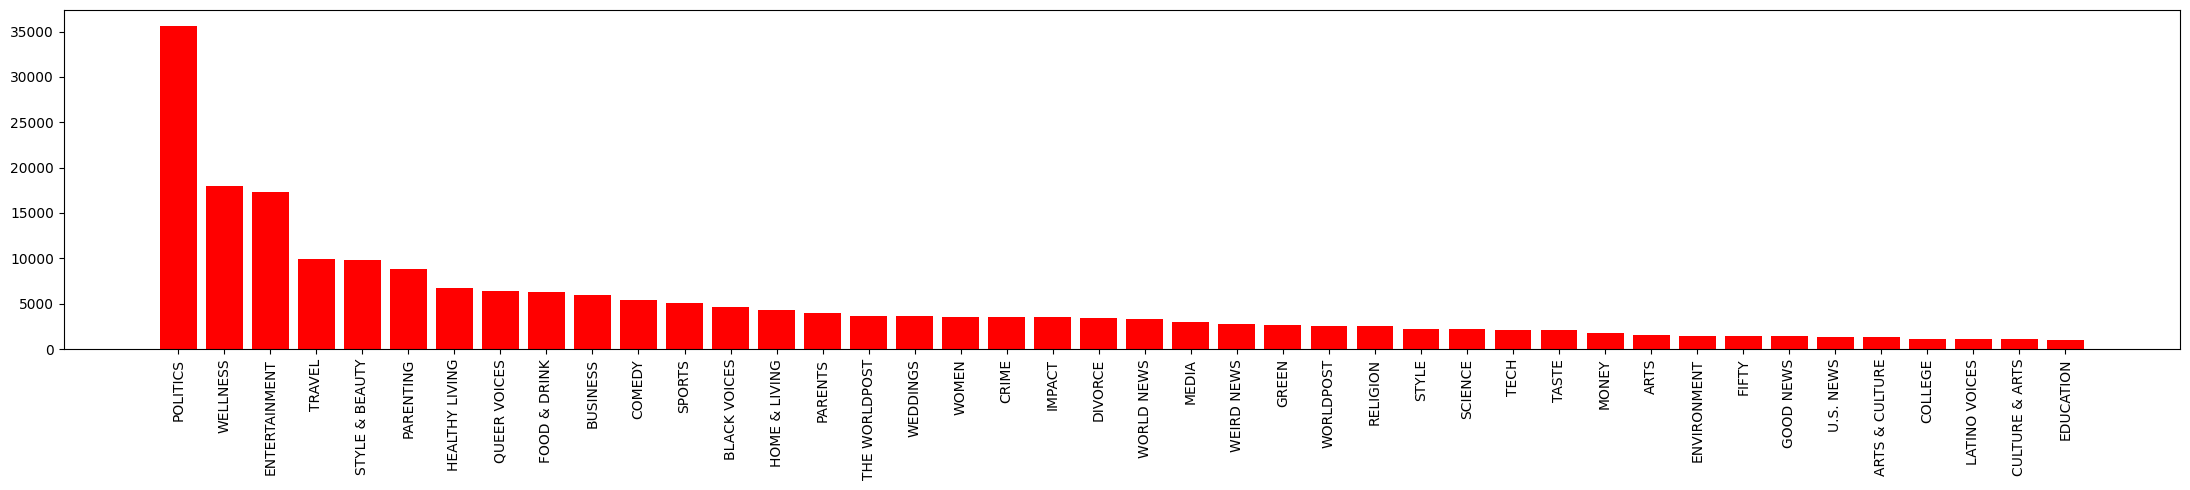

In [4]:
#Get the Categories, The Main Classification Problem
categories = sorted(df['category'].unique())
category_index = {category : idx for idx, category in enumerate(categories)}
index_category = {idx : category for category, idx in category_index.items()}
print(f"Number of Categories : {len(categories)}")

category_counts = df["category"].value_counts(sort = True, ascending = False).reset_index()
df['category'] = df['category'].apply(lambda category_name: category_index[category_name])
print(df)

#Visualising the Data
plt.figure(figsize = (22, 5))
plt.bar(category_counts['category'], category_counts['count'], color = "red")
plt.xlabel = 'Categories'
plt.ylabel = 'Number of News'
plt.title = 'Number of News in each Category'
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Class Distribution Insight

This dataset shows a significant **class imbalance**:

* **Politics**: \~35,000 samples
* **Entertainment**: \~15,000 samples
* **Education**: \~1,000 samples *(lowest)*

This imbalance can heavily affect the model’s performance, making it biased toward the dominant class (Politics) and underperform on minority classes like Education.

> **Class imbalance alert:** Using techniques like class weights, oversampling, undersampling, or focal loss will improve model fairness and generalization.


In [5]:
#Clean Text Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

#Tokenisation
texts = [clean_text(headline + ' ' + description) for headline, description in df[['headline', 'short_description']].to_numpy()]
labels = df['category'].to_numpy()

if os.path.exists('/kaggle/input/news_category_dataset_v3_tokeniser.json'):
    #Load the Tokeniser
    tokeniser = Tokenizer.from_file('/kaggle/input/news_category_dataset_v3_tokeniser.json')

else:
    #Creating the BPE Tokeniser
    tokeniser = Tokenizer(BPE(unk_token="<UNK>"))

    tokeniser.normalizer = NFKC()
    tokeniser.pre_tokenizer = Whitespace()

    trainer = BpeTrainer(
        vocab_size = 20000,
        show_progress = True,
        special_tokens=["<PAD>", "<UNK>", "<CLS>", "<SEP>", "<MASK>"])

    tokeniser.train_from_iterator(
        iterator = [news.lower().strip() for news in texts],
        trainer = trainer
    )

    tokeniser.enable_truncation(max_length = 32)
    tokeniser.enable_padding(
        pad_id = tokeniser.token_to_id("<PAD>"),
        pad_token = "<PAD>",
        length = 32
    )

    tokeniser.post_processor = TemplateProcessing(
        single="<CLS> $A <SEP>",
        pair="<CLS> $A <SEP> $B:1 <SEP>:1",
        special_tokens=[("<CLS>", tokeniser.token_to_id("<CLS>")),
                        ("<SEP>", tokeniser.token_to_id("<SEP>"))]
    )

    tokeniser.save('news_category_dataset_v3_tokeniser.json')

    print("Vocab size:", tokeniser.get_vocab_size())

    message = texts[0]
    print("Sample tokens:", tokeniser.encode(message).tokens)

class_weights = compute_class_weight('balanced', classes = np.unique(labels), y = labels)
class_weights = torch.tensor(class_weights, dtype = torch.float).to(device)




Vocab size: 20000
Sample tokens: ['<CLS>', 'over', '4', 'million', 'americans', 'roll', 'up', 'sleeves', 'for', 'omic', 'ron', 'targeted', 'covid', 'boost', 'ers', 'health', 'experts', 'said', 'it', 'is', 'too', 'early', 'to', 'predict', 'whether', 'demand', 'would', 'match', 'up', 'with', 'the', '<SEP>']


In [6]:
#Create the Dataset
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        super().__init__()

        self.data = texts
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], torch.tensor(self.labels[index], dtype = torch.long)

headlines = [clean_text(headline) for headline in df['headline'].to_numpy()]
descriptions = [clean_text(description) for description in df['short_description'].to_numpy()]

tokenised_headlines = [torch.tensor(tokeniser.encode(headline).ids) for headline in headlines]
tokenised_descriptions = [torch.tensor(tokeniser.encode(description).ids) for description in descriptions]

tokenised_texts = list(zip(tokenised_headlines, tokenised_descriptions))


train_texts, test_texts, train_labels, test_labels = train_test_split(tokenised_texts, labels, test_size = 0.2, stratify = labels)

news_train = NewsDataset(train_texts, train_labels)
news_test = NewsDataset(test_texts, test_labels)

## NewsDataset

This is a custom PyTorch-compatible dataset (`NewsDataset`) for a multiclass news classification task.

### Parameters:

* `texts`: A list of padded token sequences (as lists of integers or tensors).
* `labels`: Corresponding class labels (strings or encoded integers).

### Methods:

* `__len__`: Returns the length of the dataset
* `__getitem__`: Returns a tuple of `(token_sequence, label_tensor)`.

---


In [7]:
#DataLoaders for Resampled Dataset
batch_size = 64

train_dataloader = DataLoader(
    dataset = news_train,
    batch_size = batch_size,
    shuffle = True,
    num_workers = os.cpu_count()
)

test_dataloader = DataLoader(
    dataset = news_test,
    batch_size = batch_size,
    shuffle = False,
    num_workers = os.cpu_count()
)

In [8]:
#Custom Architecture Model
class DCAF_RNN(nn.Module):
    def __init__(self, vocab_size : int, embedding_dim : int, hidden_size : int, num_classes : int, padding_index : int):
        super().__init__()

        #Embedding
        self.embedding = nn.Sequential(
            nn.Embedding(
                num_embeddings = vocab_size,
                embedding_dim = embedding_dim,
                padding_idx = padding_index
            ),
            nn.Dropout(p = 0.35)
        )
        self.embedding_normalisation = nn.LayerNorm(embedding_dim)

        self.embedding_projection = nn.Linear(
            in_features = embedding_dim,
            out_features = hidden_size * 2
        )

        #CNN
        self.x_cnn = nn.Conv1d(
            in_channels = embedding_dim,
            out_channels = hidden_size * 2,
            kernel_size = 3,
            padding = 1
        )
        self.x_cnn_normalisation = nn.LayerNorm(hidden_size * 2)

        self.y_cnn = nn.Conv1d(
            in_channels = embedding_dim,
            out_channels = hidden_size * 2,
            kernel_size = 3,
            padding = 1
        )
        self.y_cnn_normalisation = nn.LayerNorm(hidden_size * 2)

        self.cnn_dropout = nn.Dropout(p = 0.35)

        #RNN
        self.x_rnn = nn.RNN(
            input_size = hidden_size * 2,
            hidden_size = hidden_size,
            bidirectional = True,
            batch_first = True
        )
        self.x_rnn_normalisation = nn.LayerNorm(hidden_size * 2)

        self.y_rnn = nn.RNN(
            input_size = hidden_size * 2,
            hidden_size = hidden_size,
            bidirectional = True,
            batch_first = True
        )
        self.y_rnn_normalisation = nn.LayerNorm(hidden_size * 2)
        self.rnn_dropout = nn.Dropout(p = 0.5)

        #CNN Residual Weights
        self.x_residual_cnn_weight = nn.Parameter(torch.tensor(0.5))
        self.y_residual_cnn_weight = nn.Parameter(torch.tensor(0.5))

        #Attention Residual Weights
        self.x_residual_attn_weight = nn.Parameter(torch.tensor(0.5))
        self.y_residual_attn_weight = nn.Parameter(torch.tensor(0.5))

        #Fusion Gate
        self.fusion_weight = nn.Sequential(
            nn.Linear(
                in_features = hidden_size * 4,
                out_features = hidden_size * 2
            ),
            nn.GELU(),
            nn.Dropout(p = 0.5),
            nn.Linear(
                in_features = hidden_size * 2,
                out_features = hidden_size * 2
            ),
            nn.Sigmoid()
        )

        self.final_classifier = nn.Sequential(
            nn.Linear(
                in_features = hidden_size * 2,
                out_features = hidden_size
            ),
            nn.GELU(),
            nn.Dropout(p = 0.5),
            nn.Linear(
                in_features = hidden_size,
                out_features = num_classes
            ),
        )

        self.init_weights()

    def init_weights(self):
        for layer in self.embedding:
            if isinstance(layer, nn.Embedding):
                nn.init.xavier_uniform_(layer.weight)

        nn.init.xavier_uniform_(self.embedding_projection.weight)
        nn.init.zeros_(self.embedding_projection.bias)

        for name, param in self.x_rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

        for name, param in self.y_rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

        for layer in self.fusion_weight:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

        for layer in self.final_classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x, x_lengths, y, y_lengths):
        #Embedding
        x_embedded = self.embedding_normalisation(self.embedding(x))
        y_embedded = self.embedding_normalisation(self.embedding(y))


        #CNN
        x_cnn = self.x_cnn(x_embedded.permute(0, 2, 1))
        y_cnn = self.y_cnn(y_embedded.permute(0, 2, 1))

        x_cnn_normalised = self.x_cnn_normalisation(self.cnn_dropout(x_cnn).permute(0, 2, 1)) + self.embedding_projection(x_embedded)
        y_cnn_normalised = self.y_cnn_normalisation(self.cnn_dropout(y_cnn).permute(0, 2, 1)) + self.embedding_projection(y_embedded)

        #Packing the Sequence
        x_packed_embedded = pack_padded_sequence(
            x_cnn_normalised,
            x_lengths.cpu(),
            batch_first = True,
            enforce_sorted = False
        )

        y_packed_embedded = pack_padded_sequence(
            y_cnn_normalised,
            y_lengths.cpu(),
            batch_first = True,
            enforce_sorted = False
        )

        #RNN
        x_packed_rnn, _ = self.x_rnn(x_packed_embedded)
        x_rnn, _ = pad_packed_sequence(x_packed_rnn, batch_first = True, total_length = x.size(1))

        x_residual_cnn_weight = torch.sigmoid(self.x_residual_cnn_weight)
        x_context = x_residual_cnn_weight * x_cnn_normalised + (1 - x_residual_cnn_weight) * self.x_rnn_normalisation(self.rnn_dropout(x_rnn))

        y_packed_rnn, _ = self.y_rnn(y_packed_embedded)
        y_rnn, _ = pad_packed_sequence(y_packed_rnn, batch_first = True, total_length = y.size(1))

        y_residual_cnn_weight = torch.sigmoid(self.y_residual_cnn_weight)
        y_context = y_residual_cnn_weight * y_cnn_normalised + (1 - y_residual_cnn_weight) * self.y_rnn_normalisation(self.rnn_dropout(y_rnn))

        #Cross - Attention
        x_cross_scores = torch.bmm(y_rnn, x_rnn.transpose(1, 2))
        x_cross_weights = torch.softmax(x_cross_scores, dim = -1)

        x_residual_attn_weight = torch.sigmoid(self.x_residual_attn_weight)
        x_mask = torch.arange(x_rnn.size(1), device = x_lengths.device)[None, :] < x_lengths[:, None]
        x_mask = x_mask.unsqueeze(2).float()
        x_attn = torch.bmm(x_cross_weights, x_rnn) * x_mask
        x_cross_attn = x_attn.sum(dim = 1) / (x_mask.sum(dim = 1) + 1e-8)


        y_cross_scores = torch.bmm(x_rnn, y_rnn.transpose(1, 2))
        y_cross_weights = torch.softmax(y_cross_scores, dim = -1)

        y_residual_attn_weight = torch.sigmoid(self.y_residual_attn_weight)
        y_mask = torch.arange(y_rnn.size(1), device = y_lengths.device)[None, :] < y_lengths[:, None]
        y_mask = y_mask.unsqueeze(2).float()
        y_attn = torch.bmm(y_cross_weights, y_rnn) * y_mask
        y_cross_attn = y_attn.sum(dim = 1) / (y_mask.sum(dim = 1) + 1e-8)

        #Vectors
        x_vector = x_residual_attn_weight * x_cross_attn + (1 - x_residual_attn_weight) * (x_context * x_mask).sum(dim = 1) / (x_mask.sum(dim = 1) + 1e-8)
        y_vector = y_residual_attn_weight * y_cross_attn + (1 - y_residual_attn_weight) * (y_context * y_mask).sum(dim = 1) / (y_mask.sum(dim = 1) + 1e-8)

        #Fusion Vector
        fusion_weight = self.fusion_weight(torch.cat([x_vector, y_vector], dim = 1))
        result_vector = fusion_weight * x_vector + (1 - fusion_weight) * y_vector

        logits = self.final_classifier(result_vector)
        return logits

---

# DCAF\_RNN: Dual-Channel Attention Fusion RNN for Text Classification

`DCAF_RNN` is a hybrid, dual-input architecture built for **multi-class text classification** using paired text sequences (e.g., headline and description). It combines CNN, RNN, residual fusion, and cross-attention mechanisms with a learned fusion gate.

---

## Constructor

```python
DCAF_RNN(
    vocab_size: int,
    embedding_dim: int,
    hidden_size: int,
    num_classes: int,
    padding_index: int
)
```

---

## Model Components

### 1. Embedding Layer

```python
self.embedding = nn.Sequential(
    nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_index),
    nn.Dropout(p=0.35)
)
self.embedding_normalisation = nn.LayerNorm(embedding_dim)
self.embedding_projection = nn.Linear(embedding_dim, hidden_size * 2)
```

### 2. CNN Encoders

```python
self.x_cnn = nn.Conv1d(embedding_dim, hidden_size * 2, kernel_size=3, padding=1)
self.y_cnn = nn.Conv1d(embedding_dim, hidden_size * 2, kernel_size=3, padding=1)
self.x_cnn_normalisation = nn.LayerNorm(hidden_size * 2)
self.y_cnn_normalisation = nn.LayerNorm(hidden_size * 2)
```

### 3. RNN Encoders

```python
self.x_rnn = nn.RNN(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
self.y_rnn = nn.RNN(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
self.x_rnn_normalisation = nn.LayerNorm(hidden_size * 2)
self.y_rnn_normalisation = nn.LayerNorm(hidden_size * 2)
```

### 4. Residual Weights

```python
self.x_residual_cnn_weight = nn.Parameter(torch.tensor(0.5))
self.y_residual_cnn_weight = nn.Parameter(torch.tensor(0.5))
self.x_residual_attn_weight = nn.Parameter(torch.tensor(0.5))
self.y_residual_attn_weight = nn.Parameter(torch.tensor(0.5))
```

### 5. Cross-Attention

```python
# x attends to y
x_cross_scores = torch.bmm(y_rnn, x_rnn.transpose(1, 2))
x_cross_weights = torch.softmax(x_cross_scores, dim=-1)
# y attends to x
y_cross_scores = torch.bmm(x_rnn, y_rnn.transpose(1, 2))
y_cross_weights = torch.softmax(y_cross_scores, dim=-1)
```

### 6. Fusion Gate

```python
self.fusion_weight = nn.Sequential(
    nn.Linear(hidden_size * 4, hidden_size * 2),
    nn.GELU(),
    nn.Dropout(p=0.5),
    nn.Linear(hidden_size * 2, hidden_size * 2),
    nn.Sigmoid()
)
```

### 7. Final Classifier

```python
self.final_classifier = nn.Sequential(
    nn.Linear(hidden_size * 2, hidden_size),
    nn.GELU(),
    nn.Dropout(p=0.5),
    nn.Linear(hidden_size, num_classes)
)
```

---

## Forward Pass Overview

```python
def forward(self, x, x_lengths, y, y_lengths):
    # Embed and project
    # CNN encode and residual connection
    # Pack & RNN encode
    # Residual fusion of CNN & RNN
    # Cross attention and mask
    # Combine attention vectors with context
    # Apply fusion gate on vectors
    # Final classifier on fused vector
    return logits
```

---

## Output

Returns unnormalized class logits. Use `nn.CrossEntropyLoss` for training.

---

In [9]:
#NewsModel
NewsModel1 = DCAF_RNN(
    vocab_size = tokeniser.get_vocab_size(),
    embedding_dim = 64,
    hidden_size = 96,
    num_classes = len(categories),
    padding_index = tokeniser.token_to_id("<PAD>")
)
NewsModel2 = DCAF_RNN(
    vocab_size = tokeniser.get_vocab_size(),
    embedding_dim = 64,
    hidden_size = 96,
    num_classes = len(categories),
    padding_index = tokeniser.token_to_id("<PAD>")
)

# Total Number of Parameters and Trainable Parameters
def count_parameters(Model):
    total_parameters = sum(parameter.numel() for parameter in Model.parameters())
    trainable_parameters = sum(parameter.numel() for parameter in Model.parameters() if parameter.requires_grad)

    print(f"Total Parameters: {total_parameters}")
    print(f"Trainable Parameters: {trainable_parameters}")

count_parameters(NewsModel1), count_parameters(NewsModel2)

Total Parameters: 1613198
Trainable Parameters: 1613198
Total Parameters: 1613198
Trainable Parameters: 1613198


(None, None)

In [12]:
#Training Loop
def train_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function,
    optimiser : torch.optim.Optimizer,
    scheduler : torch.optim.lr_scheduler,
    device : torch.device = device
):
    model.train()

    train_loss, train_accuracy = 0, 0
    model.to(device)

    for batch, ((X, Y), z) in enumerate(dataloader):
        X, Y, z = X.to(device), Y.to(device), z.to(device)

        headline_lengths = (X != tokeniser.token_to_id("<PAD>")).sum(dim = 1)
        description_lengths = (Y != tokeniser.token_to_id("<PAD>")).sum(dim = 1)

        zLogits = model(X, headline_lengths, Y, description_lengths)
        zPreds = torch.argmax(torch.softmax(zLogits, dim = 1), dim = 1)

        loss = loss_function(zLogits, z)
        train_loss += loss.item()

        optimiser.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2.0)
        optimiser.step()
        scheduler.step()

        accuracy = accuracy_function(zPreds, z)
        train_accuracy += accuracy.item()

        if (batch + 1) % 800 == 0:
            print(f'Looked at Batch No: {batch + 1}. {(batch + 1) * len(X)} / {len(dataloader.dataset)} samples')

    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_accuracy * 100:.2f}%")

    return train_loss, train_accuracy

def test_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function : Accuracy,
    precision: Precision,
    recall: Recall,
    f1_score: F1Score,
    display_scores : bool = False,
    device : torch.device = device
):
    model.eval()

    test_loss, test_accuracy = 0, 0
    model.to(device)

    all_preds = []
    all_targets = []
    with torch.inference_mode():
        for ((X, Y), z) in dataloader:
            X, Y, z = X.to(device), Y.to(device), z.to(device)

            headline_lengths = (X != tokeniser.token_to_id("<PAD>")).sum(dim = 1)
            description_lengths = (Y != tokeniser.token_to_id("<PAD>")).sum(dim = 1)

            zLogits = model(X, headline_lengths, Y, description_lengths)
            zPreds = torch.argmax(torch.softmax(zLogits, dim = 1), dim = 1)

            loss = loss_function(zLogits, z)
            test_loss += loss.item()

            accuracy = accuracy_function(zPreds, z)
            test_accuracy += accuracy.item()

            all_preds.append(zPreds)
            all_targets.append(z)

        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)

        print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy * 100:.2f}%")
        if display_scores:
          test_precision = precision(all_preds, all_targets)
          test_recall = recall(all_preds, all_targets)
          test_f1_score = f1_score(all_preds, all_targets)
          for i in range(len(categories)):
            print(f"Category ({categories[i]}) : Test Precision: {test_precision[i] * 100:.2f}% | Test Recall {test_recall[i] * 100:.2f}% | Test F1 Score {test_f1_score[i] * 100:.2f}%")

    return test_loss, test_accuracy

In [13]:
#Optimiser and Loss Function
loss = nn.CrossEntropyLoss(label_smoothing = 0.1, weight = class_weights)

learning_rate = 5e-4
optimiser = torch.optim.AdamW(
    params = NewsModel1.parameters(),
    lr = learning_rate,
    weight_decay = 1e-2
)

n_epochs = 12

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimiser,
    max_lr = 5e-4,
    anneal_strategy = "cos",
    total_steps = n_epochs * len(train_dataloader),
    div_factor = 10,
    final_div_factor = 100
)

accuracy = Accuracy(task = "multiclass", num_classes = len(categories)).to(device)
precision = Precision(task = 'multiclass', num_classes = len(categories), average = None).to(device)
recall = Recall(task = 'multiclass', num_classes = len(categories), average = None).to(device)
f1_score = F1Score(task = 'multiclass', num_classes = len(categories), average = None).to(device)

#Timer Function
def display_time(start_time,
              end_time,
              device : torch.device = device):
    time = end_time - start_time
    print(f"Total Time : {time} on device {device}.")

In [18]:
#Training Model
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

#Training
def training(
    model : torch.nn.Module,
    epochs : int,
    train_dataloader : torch.utils.data.DataLoader,
    test_dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function,
    optimiser : torch.optim.Optimizer,
    scheduler : torch.optim.lr_scheduler,
    device : torch.device = device
):
    for epoch in tqdm(range(epochs)):

        for param in model.embedding.parameters():
            param.requires_grad = False if epoch < 3 else True

        print(f'Epochs : {epoch + 1}\n---------')
        train_loss, train_accuracy = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_function = loss_function,
            accuracy_function = accuracy_function,
            optimiser = optimiser,
            scheduler = scheduler,
            device = device
          )

        test_loss, test_accuracy = test_step(
            model = model,
            dataloader = test_dataloader,
            loss_function = loss_function,
            accuracy_function = accuracy_function,
            precision = precision,
            recall = recall,
            f1_score = f1_score,
            device = device
        )

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)

        for param_group in optimiser.param_groups:
            print(f"Learning Rate: {param_group['lr']:.2e}")

---

## Optimizer, Scheduler, Loss & Evaluation Metrics

### Loss Function

#### With Class Weights:

```python
loss = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)
```

#### Without Class Weights:

```python
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
```

* Used for multi-class classification tasks.
* Applies label smoothing to prevent overconfidence.
* Optionally weights each class to handle class imbalance.

---

### Optimizer

```python
learning_rate = 5e-4
optimiser = torch.optim.AdamW(
    params=NewsModel.parameters(),
    lr=learning_rate,
    weight_decay=1e-2
)
```

* AdamW is a variant of Adam with decoupled weight decay.
* `weight_decay=1e-2` provides L2 regularization.
* `lr=5e-4` sets the peak learning rate.

---

### Learning Rate Scheduler

```python
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimiser,
    max_lr=5e-4,
    anneal_strategy="cos",
    total_steps=n_epochs * len(train_dataloader),
    div_factor=10,
    final_div_factor=100
)
```

* `max_lr` is the maximum learning rate reached during training.
* Starts at `max_lr / div_factor`, anneals back to `max_lr / final_div_factor`.
* Cosine annealing (`anneal_strategy="cos"`) ensures smooth learning rate transitions.

---

### Evaluation Metrics

```python
accuracy = Accuracy(task="multiclass", num_classes=len(categories)).to(device)
precision = Precision(task="multiclass", num_classes=len(categories), average=None).to(device)
recall = Recall(task="multiclass", num_classes=len(categories), average=None).to(device)
f1_score = F1Score(task="multiclass", num_classes=len(categories), average=None).to(device)
```

* `Accuracy`: Proportion of correct predictions over total predictions.
* `Precision`: Per-class precision, evaluates prediction correctness.
* `Recall`: Per-class recall, evaluates coverage of true labels.
* `F1Score`: Harmonic mean of precision and recall per class.
* `average=None`: Returns metrics per class rather than a single aggregated value.

---

### Timer Utility

```python
def display_time(start_time, end_time, device: torch.device = device):
    time = end_time - start_time
    print(f"Total Time : {time} on device {device}.")
```

* Displays the total execution time for training or evaluation routines.

---

In [19]:
#Model Before Training
print("Model Evaluation Before Training:")
test_step(
    model = NewsModel1,
    dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    precision = precision,
    recall = recall,
    f1_score = f1_score,
    device = device
)

for param_group in optimiser.param_groups:
    print(f"Learning Rate: {param_group['lr']:.2e}")


print("---------------------------------------------------------------------------------------")

start_time = timer()

training(
    model = NewsModel1,
    epochs = n_epochs,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    optimiser = optimiser,
    scheduler = scheduler,
    device = device
)

end_time = timer()
display_time(
    start_time  = start_time,
    end_time = end_time,
    device = device
)

Model Evaluation Before Training:
Test Loss: 4.11232 | Test Accuracy: 2.28%
Learning Rate: 5.00e-05
---------------------------------------------------------------------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

Epochs : 1
---------
Looked at Batch No: 800. 51200 / 167621 samples
Looked at Batch No: 1600. 102400 / 167621 samples
Looked at Batch No: 2400. 153600 / 167621 samples
Train Loss: 4.07815 | Train Accuracy: 2.50%
Test Loss: 4.00564 | Test Accuracy: 4.33%
Learning Rate: 1.30e-04
Epochs : 2
---------
Looked at Batch No: 800. 51200 / 167621 samples
Looked at Batch No: 1600. 102400 / 167621 samples
Looked at Batch No: 2400. 153600 / 167621 samples
Train Loss: 3.94650 | Train Accuracy: 5.74%
Test Loss: 3.79981 | Test Accuracy: 8.91%
Learning Rate: 3.14e-04
Epochs : 3
---------
Looked at Batch No: 800. 51200 / 167621 samples
Looked at Batch No: 1600. 102400 / 167621 samples
Looked at Batch No: 2400. 153600 / 167621 samples
Train Loss: 3.82034 | Train Accuracy: 7.70%
Test Loss: 3.73040 | Test Accuracy: 12.73%
Learning Rate: 4.70e-04
Epochs : 4
---------
Looked at Batch No: 800. 51200 / 167621 samples
Looked at Batch No: 1600. 102400 / 167621 samples
Looked at Batch No: 2400. 153600 / 167621 s

In [20]:
test_step(
    model = NewsModel1,
    dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    precision = precision,
    recall = recall,
    f1_score = f1_score,
    display_scores = True,
    device = device
)

Test Loss: 2.59557 | Test Accuracy: 53.72%
Category (ARTS) : Test Precision: 28.63% | Test Recall 48.34% | Test F1 Score 35.96%
Category (ARTS & CULTURE) : Test Precision: 32.63% | Test Recall 46.27% | Test F1 Score 38.27%
Category (BLACK VOICES) : Test Precision: 41.38% | Test Recall 46.35% | Test F1 Score 43.72%
Category (BUSINESS) : Test Precision: 47.94% | Test Recall 40.82% | Test F1 Score 44.09%
Category (COLLEGE) : Test Precision: 32.43% | Test Recall 47.16% | Test F1 Score 38.43%
Category (COMEDY) : Test Precision: 41.92% | Test Recall 50.93% | Test F1 Score 45.99%
Category (CRIME) : Test Precision: 45.93% | Test Recall 57.87% | Test F1 Score 51.21%
Category (CULTURE & ARTS) : Test Precision: 31.70% | Test Recall 45.12% | Test F1 Score 37.24%
Category (DIVORCE) : Test Precision: 68.48% | Test Recall 77.37% | Test F1 Score 72.65%
Category (EDUCATION) : Test Precision: 26.76% | Test Recall 48.77% | Test F1 Score 34.55%
Category (ENTERTAINMENT) : Test Precision: 75.33% | Test Reca

(2.595566302037421, 0.5371583969538448)

In [21]:
#Optimiser and Loss Function
loss = nn.CrossEntropyLoss(label_smoothing = 0.1)

learning_rate = 5e-4
optimiser = torch.optim.AdamW(
    params = NewsModel2.parameters(),
    lr = learning_rate,
    weight_decay = 1e-2
)

n_epochs = 12

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimiser,
    max_lr = 5e-4,
    anneal_strategy = "cos",
    total_steps = n_epochs * len(train_dataloader),
    div_factor = 10,
    final_div_factor = 100
)

accuracy = Accuracy(task = "multiclass", num_classes = len(categories)).to(device)
precision = Precision(task = 'multiclass', num_classes = len(categories), average = None).to(device)
recall = Recall(task = 'multiclass', num_classes = len(categories), average = None).to(device)
f1_score = F1Score(task = 'multiclass', num_classes = len(categories), average = None).to(device)

In [22]:
#Model Before Training
print("Model Evaluation Before Training:")
test_step(
    model = NewsModel2,
    dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    precision = precision,
    recall = recall,
    f1_score = f1_score,
    device = device
)

for param_group in optimiser.param_groups:
    print(f"Learning Rate: {param_group['lr']:.2e}")


print("---------------------------------------------------------------------------------------")

start_time = timer()

training(
    model = NewsModel2,
    epochs = n_epochs,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    optimiser = optimiser,
    scheduler = scheduler,
    device = device
)

end_time = timer()
display_time(
    start_time  = start_time,
    end_time = end_time,
    device = device
)

Model Evaluation Before Training:
Test Loss: 3.73558 | Test Accuracy: 3.17%
Learning Rate: 5.00e-05
---------------------------------------------------------------------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

Epochs : 1
---------
Looked at Batch No: 800. 51200 / 167621 samples
Looked at Batch No: 1600. 102400 / 167621 samples
Looked at Batch No: 2400. 153600 / 167621 samples
Train Loss: 3.37619 | Train Accuracy: 17.85%
Test Loss: 3.15959 | Test Accuracy: 22.90%
Learning Rate: 1.30e-04
Epochs : 2
---------
Looked at Batch No: 800. 51200 / 167621 samples
Looked at Batch No: 1600. 102400 / 167621 samples
Looked at Batch No: 2400. 153600 / 167621 samples
Train Loss: 3.16798 | Train Accuracy: 23.10%
Test Loss: 3.04079 | Test Accuracy: 26.00%
Learning Rate: 3.14e-04
Epochs : 3
---------
Looked at Batch No: 800. 51200 / 167621 samples
Looked at Batch No: 1600. 102400 / 167621 samples
Looked at Batch No: 2400. 153600 / 167621 samples
Train Loss: 3.08266 | Train Accuracy: 24.78%
Test Loss: 2.97538 | Test Accuracy: 27.21%
Learning Rate: 4.70e-04
Epochs : 4
---------
Looked at Batch No: 800. 51200 / 167621 samples
Looked at Batch No: 1600. 102400 / 167621 samples
Looked at Batch No: 2400. 153600 / 167

In [23]:
test_step(
    model = NewsModel2,
    dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    precision = precision,
    recall = recall,
    f1_score = f1_score,
    display_scores = True,
    device = device
)

Test Loss: 1.86664 | Test Accuracy: 62.73%
Category (ARTS) : Test Precision: 46.71% | Test Recall 25.83% | Test F1 Score 33.26%
Category (ARTS & CULTURE) : Test Precision: 45.95% | Test Recall 25.37% | Test F1 Score 32.69%
Category (BLACK VOICES) : Test Precision: 50.73% | Test Recall 37.95% | Test F1 Score 43.42%
Category (BUSINESS) : Test Precision: 50.27% | Test Recall 46.74% | Test F1 Score 48.44%
Category (COLLEGE) : Test Precision: 48.70% | Test Recall 24.45% | Test F1 Score 32.56%
Category (COMEDY) : Test Precision: 53.98% | Test Recall 46.48% | Test F1 Score 49.95%
Category (CRIME) : Test Precision: 49.51% | Test Recall 56.88% | Test F1 Score 52.94%
Category (CULTURE & ARTS) : Test Precision: 60.00% | Test Recall 29.30% | Test F1 Score 39.38%
Category (DIVORCE) : Test Precision: 75.96% | Test Recall 75.18% | Test F1 Score 75.57%
Category (EDUCATION) : Test Precision: 36.79% | Test Recall 19.21% | Test F1 Score 25.24%
Category (ENTERTAINMENT) : Test Precision: 67.04% | Test Reca

(1.866638413640379, 0.6272891221155648)

In [24]:
#Save Model Function
def save_model(folder : str,
             file_name : str,
             model : torch.nn.Module):
    modelPath = Path(folder)
    modelPath.mkdir(parents = True, exist_ok = True)

    modelName = file_name
    modelSavePath = modelPath / modelName

    print(f"Saving Model to : {modelSavePath}")
    torch.save(model.state_dict(), modelSavePath)

#Load Model Function
def load_model(folder : str,
             file_name : str,
             model : torch.nn.Module):
    modelPath = Path(folder)

    modelName = file_name
    modelSavePath = modelPath / modelName

    model.load_state_dict(torch.load(modelSavePath, weights_only = True))

In [26]:
save_model(
    folder = "/kaggle/working/",
    file_name = "news_category_classification_v1.pth",
    model = NewsModel1
)
save_model(
    folder = "/kaggle/working/",
    file_name = "news_category_classification_v2.pth",
    model = NewsModel2
)

Saving Model to : /kaggle/working/news_category_classification_v1.pth
Saving Model to : /kaggle/working/news_category_classification_v2.pth
